# Prosper Loan Data
## by Bruce Collins

## Table of Contents
<ul>
<li><a href="#prelim">Preliminary Wrangling</a></li>
<li><a href="#univar">Univariate Exploration</a></li>
<li><a href="#bivar">Bivariate Exploration</a></li>
<li><a href="#multivar">Multivariate Exploration</a></li>
</ul>

<a id='prelim'></a>
## Preliminary Wrangling

> According to [Wikipedia](https://en.wikipedia.org/wiki/Prosper_Marketplace) "Prosper Marketplace is America's first peer-to-peer lending marketplace ... Borrowers request personal loans on Prosper and investors (individual or institutional) can fund anywhere from \\$2,000 to \$35,000 per loan request. Investors can consider borrowers’ credit scores, ratings, and histories and the category of the loan. Prosper handles the servicing of the loan and collects and distributes borrower payments and interest back to the loan investors." 
>
> The dataset being investigated here consists of data on Prosper Marketplace loans originated between 11/15/2005 and 3/12/2014. It contains eighty-one variables for these loans included such critical information as 
> * Various keys like listing key, loan key and member key
> * Loan status ("completed", "current", "past due" (along with 6 categories of the number of days payment was late), "defaulted", "chargedoff", "canceled" and "final payment in progress")
> * Various dates like listing date, origination date and closed date (if closed)
> * Various loan parameters such has loan amount, interest rates, estimated yield, estimated return, monthly payment amount
> * Various borrower data such has employment status, income, income to debt ratio, credit scores/ratings, total indebtedness, number of revolving credit accounts, 
> * Various investor data including the number of investors and the number of friends that invested
>
> While personally identifying information has been removed this dataset allows the exploration of investor returns and risks on the Prosper platform and the factors that might predict successful outcomes.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import datetime
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

### Gather
>
> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

In [2]:
prosper_loans = pd.read_csv('prosperLoanData.csv')
prosper_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
ListingKey                             113937 non-null object
ListingNumber                          113937 non-null int64
ListingCreationDate                    113937 non-null object
CreditGrade                            28953 non-null object
Term                                   113937 non-null int64
LoanStatus                             113937 non-null object
ClosedDate                             55089 non-null object
BorrowerAPR                            113912 non-null float64
BorrowerRate                           113937 non-null float64
LenderYield                            113937 non-null float64
EstimatedEffectiveYield                84853 non-null float64
EstimatedLoss                          84853 non-null float64
EstimatedReturn                        84853 non-null float64
ProsperRating (numeric)                84853 non-null float64
ProsperRating (Alpha) 

### Assess
> 
> In this section the data will be assessed for tidiness and quality issues.

In [3]:
# Investigate the tidiness issue of having both member and loan information contained in a single table
prosper_loans.MemberKey.duplicated().value_counts()

False    90831
True     23106
Name: MemberKey, dtype: int64

> The large number of MemberKey values being duplicated (20%) means that borrower data duplication is certainly occuring. One possible explanation is that these borrowers are taking out multiple loans. 
>
> Next let's look at the LoanKey column to see how many unique loans are in the dataset

In [4]:
prosper_loans.LoanKey.nunique()

113066

> Of the 113937 rows in the dataset, 113066 have unique LoanKey values so 113937 - 113066 = 871 of the rows have duplicate LoanKey values. Let's investigate these duplicate LoanKey values

In [5]:
dup_loankeys = prosper_loans[prosper_loans.LoanKey.duplicated()].LoanKey
dup_loankey_recs = prosper_loans[prosper_loans.LoanKey.isin(dup_loankeys)]

dup_loankey_recs.head().LoanKey

8      02163700809231365A56A1C
9      02163700809231365A56A1C
29     A8B83704317372651543A02
176    BBE63704110073042883EB9
313    63EB36981030549241BDB4E
Name: LoanKey, dtype: object

> Manual inspection of these 4 duplicated LoanKey values reveal a pattern. First, all of the fields of records with the same LoanKey contain the same value _except_ ProsperScore. The data dictionary for the Prosper Loan dataset gives the following description for this variable: "A custom risk score built using historical Prosper data. The score ranges from 1-10, with 10 being the best, or lowest risk score. Applicable for loans originated after July 2009." 
>
> Since these are clearly duplicate records, they should be cleaned. The ProsperScore value will be taken as the average of the values in the duplicate rows with the same LoanKey.

In [6]:
# Assess the duplicate LoanKey values programmatically
num_rows, num_cols = dup_loankey_recs.shape
# sort dup_loankey_recs dataframe by LoanKey (so that duplicates occur consecutively)
sorted_dup_loankey_recs = dup_loankey_recs.sort_values(by='LoanKey')
# create boolean series with True in positions corresponding to first of records with duplicate LoanKey values
first_dup = sorted_dup_loankey_recs.LoanKey.duplicated()
flg = 0
for i in range(num_rows):
    if first_dup.iloc[i] == False:
        row0 = sorted_dup_loankey_recs.iloc[i,:].dropna()
    else:
        row1 = sorted_dup_loankey_recs.iloc[i,:].dropna()
        unique_cols = row0 != row1
        s = str(row1[unique_cols])
        l = s.split()
        if len(l) > 6  or l[0] != 'ProsperScore':
            print(l)
            flg = 1
if flg == 0:
    print('The only column that differs in the duplicated LoanKey rows is ProsperScore')

The only column that differs in the duplicated LoanKey rows is ProsperScore


> The above programmatic assessment code confirms that the duplicated LoanKey rows only differ in the ProsperScore column. The task of removing these duplicates will need to be performed during the cleaning phase.

#### Assessment Documentation
>
> 1. Remove duplicate rows with same LoanKey values and set the ProsperScore value to the average of the values in the original rows with the duplicated LoanKey.
>
> 2. Columns containing dates are in string format. They need to be converted to datetime object format in order to be most useful during analysis.
>
> **Note** the potential tidiness issue of having both borrower and loan information in the single table mentioned above was determined not to be worth cleaning because much of the much interesting borrower variables can actually change over time and the value at the time of listing on the platform is what's important and this is exactly what is captured in the original format.

### Cleaning
#### Define
> 1. Remove duplicate LoanKey rows by averaging the ProsperScore over rows with the same LoanKey value, dropping all but on of these rows and replacing the value of ProsperScore with the average value.
> 2. Once LoanKey duplicates are removed, make the LoanKey the index of the dataframe to improve access performance.
> 3. Convert ListingCreationDate, ClosedDate, DateCreditPulled, LoanOriginationDate columns to datetime format using Pandas .to_datetime() function.
#### Code

In [7]:
# Clean the duplicate LoanKey values programmatically
prosper_loans_clean = prosper_loans.drop_duplicates(subset='LoanKey')
prosper_loans_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113066 entries, 0 to 113936
Data columns (total 81 columns):
ListingKey                             113066 non-null object
ListingNumber                          113066 non-null int64
ListingCreationDate                    113066 non-null object
CreditGrade                            28953 non-null object
Term                                   113066 non-null int64
LoanStatus                             113066 non-null object
ClosedDate                             55076 non-null object
BorrowerAPR                            113041 non-null float64
BorrowerRate                           113066 non-null float64
LenderYield                            113066 non-null float64
EstimatedEffectiveYield                83982 non-null float64
EstimatedLoss                          83982 non-null float64
EstimatedReturn                        83982 non-null float64
ProsperRating (numeric)                83982 non-null float64
ProsperRating (Alpha) 

In [8]:
# Next calculate the averages of the ProsperScore values in the duplicate loans and update prosper_loans_clean
num_rows, num_cols = sorted_dup_loankey_recs.shape
# Use previously sorted dup_loankey_recs dataframe by LoanKey (so that duplicates occur consecutively)
flg = 0
test_dict = {}
for i in range(num_rows):
    if first_dup.iloc[i] == False:
        # close out previous average ProsperScore calculation
        if flg == 1:    # skip this the first time
            score_avg = score_sum / score_cnt
            idx = prosper_loans_clean[prosper_loans_clean['LoanKey'] == lk].index
            prosper_loans_clean.loc[idx, 'ProsperScore'] = score_avg
            test_dict.update({lk : score_avg})
        
        # initialize ProsperScore sum and count variables and save the LoanKey value
        row0 = sorted_dup_loankey_recs.iloc[i,:]
        score_sum = row0.ProsperScore
        score_cnt = 1
        lk = row0.LoanKey
    else:
        row1 = sorted_dup_loankey_recs.iloc[i,:]
        score_sum += row1.ProsperScore
        score_cnt += 1
        
    flg = 1
        
# close out last average ProsperScore calculation
score_avg = score_sum / score_cnt
idx = prosper_loans_clean[prosper_loans_clean['LoanKey'] == lk].index
prosper_loans_clean.loc[idx, 'ProsperScore'] = score_avg
test_dict.update({lk : score_avg})

In [9]:
# 3. Convert the ListingCreationDate, ClosedDate, DateCreditPulled, LoanOriginationDate columns to datetime format
prosper_loans_clean.loc[:,'ListingCreationDate'] = pd.to_datetime(prosper_loans_clean['ListingCreationDate'])
prosper_loans_clean.loc[:,'ClosedDate'] = pd.to_datetime(prosper_loans_clean['ClosedDate'])
prosper_loans_clean.loc[:,'DateCreditPulled'] = pd.to_datetime(prosper_loans_clean['DateCreditPulled'])
prosper_loans_clean.loc[:,'LoanOriginationDate'] = pd.to_datetime(prosper_loans_clean['LoanOriginationDate'])
prosper_loans_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113066 entries, 0 to 113936
Data columns (total 81 columns):
ListingKey                             113066 non-null object
ListingNumber                          113066 non-null int64
ListingCreationDate                    113066 non-null datetime64[ns]
CreditGrade                            28953 non-null object
Term                                   113066 non-null int64
LoanStatus                             113066 non-null object
ClosedDate                             55076 non-null datetime64[ns]
BorrowerAPR                            113041 non-null float64
BorrowerRate                           113066 non-null float64
LenderYield                            113066 non-null float64
EstimatedEffectiveYield                83982 non-null float64
EstimatedLoss                          83982 non-null float64
EstimatedReturn                        83982 non-null float64
ProsperRating (numeric)                83982 non-null float64
Prospe

#### Test
> Look at the previously duplicated values and verify that duplicates have been cleaned and that the ProsperScore is correct

In [10]:
# Make sure that all instances of duplicated LoanKey values have been removed
prosper_loans_clean.LoanKey.duplicated().value_counts()

False    113066
Name: LoanKey, dtype: int64

In [11]:
# 2. Change the index to the LoanKey
loans_clean = prosper_loans_clean.set_index('LoanKey')
loans_clean.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
LoanKey,,,,,,,,,,,,,,,,,,,,,
E33A3400205839220442E84,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263,C,36,Completed,2009-08-14,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
9E3B37071505919926B1D82,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900,NaN,36,Current,NaT,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
6954337960046817851BCB2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090,HR,36,Completed,2009-12-17,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
A0393664465886295619C51,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010,NaN,36,Current,NaT,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
A180369302188889200689E,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097,NaN,36,Current,NaT,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [12]:
# go thru list of previously duplicate LoanKeys and verify that the ProsperScore is as expected
flg = 0
for loan_key in test_dict:
    if loans_clean.loc[loan_key, 'ProsperScore'] != test_dict[loan_key]:
        flg = 1
        print('Test Failed: LoanKey = ', loan_key, 'ProsperScore = ', loans_clean.loc[loan_key, 'ProsperScore'], 'Expected = ', test_dict[loan_key])
        
if flg == 0:
    print('Test Passed!!')

Test Passed!!


In [13]:
# check for duplicate ListingKey
loans_clean.ListingKey.duplicated().value_counts()

False    113066
Name: ListingKey, dtype: int64

In [14]:
# Add a column to loans_clean that indicates loans that have LoanStatus of Chargedoff, Defaulted or Past Due by more than 30 days
loans_clean['TroubledLoan'] = loans_clean.apply(lambda row: (row.LoanStatus == 'Chargedoff' or row.LoanStatus == 'Defaulted' 
                               or row.LoanStatus == 'Past Due (31-60 days)' or row.LoanStatus == 'Past Due (61-90 days)' 
                               or row.LoanStatus == 'Past Due (91-120 days)' or row.LoanStatus == 'Past Due (>120 days)'), axis=1)
loans_clean.TroubledLoan.value_counts()

False    95064
True     18002
Name: TroubledLoan, dtype: int64

In [15]:
# Add PostRelaunch column to indicate which loans were originated after the Prosper website was relaunched in July 2009 (True) 
#     or before (False)
loans_clean['PostRelaunch'] = (loans_clean.LoanOriginationDate > datetime.datetime(2009, 7, 1))
loans_clean.PostRelaunch.value_counts()

True     84113
False    28953
Name: PostRelaunch, dtype: int64

In [16]:
# Write the cleaned data out to a csv file for visual assessment
with open('prosperLoansClean.csv', 'w+', encoding='utf-8', newline='',) as file:
        loans_clean.to_csv(file)

### What is the structure of your dataset?

> The prosper loan dataset after cleaning consists of 113066 rows and 81 columns. It is primarily organized around funded loans which represent a borrower applying for a loan on the platform (represented as a "listing") which successfully attracts one or more investors and a loan actually getting funded. The data appears in a single table containing both loan details and borrower details at the time that the loan was originated. This potental untidiness of having both borrower and loan information in the same table was decided to be acceptable for the purposes of this analysis since much of the borrower information needs to be sampled at the time of each loan origination and, thus, is not static.

### What is/are the main feature(s) of interest in your dataset?

> The primary features of interest in this dataset are the following:
> * What are the success rates of loans on the Prosper Marketplace?
> * Are there borrower characteristics that correlate with loan outcome?
> * Are there loan characteristics that correlate with loan outcome?
> * Loan performance from an investor perspective.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> * The LoanStatus column provides indications of the "success" of the loan for the loans, at least for those that closed during the date range of the dataset. Since loan success on the Prosper Marketplace platform is a primary question of investigation this feature of the dataset is critical.
> * In addition to loan status the data contains details of each loan such as loan amount, interest rates, estimated yield, estimated return, monthly payment amount
> * The data contains a number of variables characterizing the borrower such as employment information, income, income to debt ratio, multiple credit scores and ratings, number of revolving credit accounts, group affiliation and deliquencies info.
> * There is also some variables that describe the investors such as number of investors, number of friends that invest and the amount invested by these friends.
> * There are variables that convey performance of a loan from the investors' perspective.

<a id='univar'></a>
## Univariate Exploration

> Let's start by investigating each of the primary variables of interest

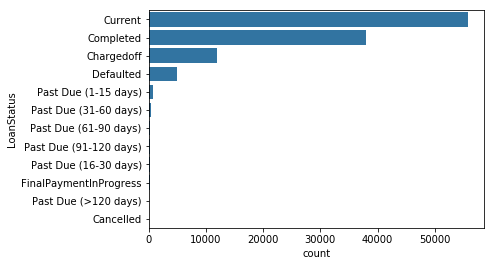

In [17]:
# Plot the distribution of the LoanStatus categorical variable
base_color=sb.color_palette()[0]
type_order=loans_clean['LoanStatus'].value_counts().index
sb.countplot(data=loans_clean, y='LoanStatus', color=base_color, order=type_order)

> **Note** that the "past due" categories only apply to loans that were not closed when the dataset was collected. While these may be of interest, they cannot be used as an indication of loan "success" as we define it here (whether the loan got repaid). In this regard the categories of interest are Completed, Chargedoff, Defaulted and Cancelled. This should be the LoanStatus values for loans that have been closed. We should be able to determine whether a loan is closed by rows that have a non-null ClosedDate value. Let's separate the closed loans and open loans into separate dataframes

In [18]:
# Separate the closed and still open loans bu filtering on the ClosedDate column
loans_closed = loans_clean.dropna(subset=['ClosedDate'])
loans_closed.shape

(55076, 82)

In [19]:
# Now the open loans
loans_open = loans_clean[loans_clean['ClosedDate'].isnull()]
loans_open.shape

(57990, 82)

> So 48.7% of the loans represented in the dataset are closed and 51.3% are open. 

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

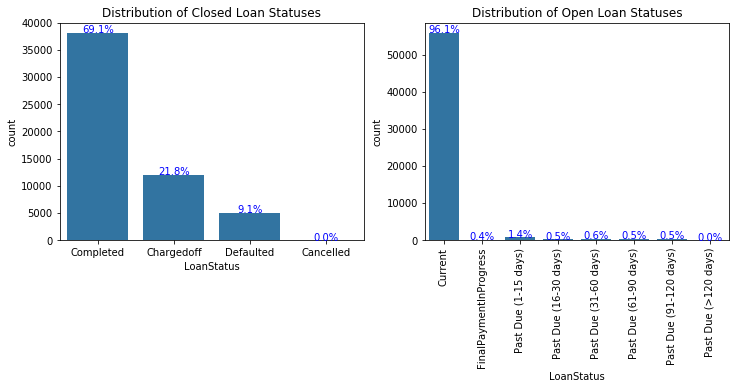

In [20]:
# Plot the distribution of the LoanStatus categorical variable in two subplots - one for closed and the other for open
fig, axes = plt.subplots(1,2,squeeze=False,figsize = (12,4))
base_color=sb.color_palette()[0]
type_order1=loans_closed['LoanStatus'].value_counts().index
sb.countplot(data=loans_closed, x='LoanStatus', color=base_color, order=type_order1, ax=axes[0,0])
type_order2=['Current','FinalPaymentInProgress','Past Due (1-15 days)','Past Due (16-30 days)','Past Due (31-60 days)','Past Due (61-90 days)','Past Due (91-120 days)','Past Due (>120 days)']
sb.countplot(data=loans_open, x='LoanStatus', color=base_color, order=type_order2, ax=axes[0,1])
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels for left subplot
plt.sca(axes[0,0])
# Label bars with proportions
n_points = loans_closed.shape[0]
cat_counts = loans_closed['LoanStatus'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just above the top of the bar
    plt.text(loc, count+10, pct_string, ha = 'center', color = 'b')

axes[0,0].set_title('Distribution of Closed Loan Statuses')

# loop through each pair of locations and labels for left subplot
plt.sca(axes[0,1])
# Label bars with proportions
n_points = loans_open.shape[0]
cat_counts = loans_open['LoanStatus'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just above the top of the bar
    plt.text(loc, count+20, pct_string, ha = 'center', color = 'b')
    
axes[0,1].set_title('Distribution of Open Loan Statuses')
plt.xticks(rotation='90')

> This plot shows that the proportion of successfully "completed" loans was 69.1% and that the unsuccessful completed loans (sum of "defaulted" and "chargedoff" loans) was 30.9%. "Cancelled" loans are ones that are funded by investors but the borrower never accepted the funds. The proportion of loans in this latter category is negligible.

In [21]:
# Plot the distribution of the open LoanStatus categorical variable
base_color=sb.color_palette()[0]
type_order=loans_open['LoanStatus'].value_counts().index
#sb.countplot(data=loans_open, y='LoanStatus', color=base_color, order=type_order)
loans_open.LoanStatus.value_counts()

Current                   55730
Past Due (1-15 days)        800
Past Due (31-60 days)       361
Past Due (61-90 days)       311
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      203
Past Due (>120 days)         16
Name: LoanStatus, dtype: int64

> There is a disparity between the proportion of unsuccessful loans among the closed loans (30.9%) and the open past due loans (only 3.9%). The open loans probably were originated towards the end of the 8.5 years that the dataset spans (the average term of the loans is over 36 months) so differences in the repayment pattern over this timespan might account for this disparity. The following investigates timeseries for some of the variables.

In [22]:
# Create a timeseries dataframe indexed by LoanOriginationDate and containing the columns that timeseries might be interesting
ts_loans = loans_clean[['LoanOriginationDate', 'LoanStatus', 'BorrowerRate','ClosedDate','Investors','TroubledLoan','LoanOriginalAmount','Term']].copy()
ts_loans.set_index('LoanOriginationDate', inplace=True)
ts_loans.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113066 entries, 2007-09-12 to 2014-01-21
Data columns (total 7 columns):
LoanStatus            113066 non-null object
BorrowerRate          113066 non-null float64
ClosedDate            55076 non-null datetime64[ns]
Investors             113066 non-null int64
TroubledLoan          113066 non-null bool
LoanOriginalAmount    113066 non-null int64
Term                  113066 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.1+ MB


In [23]:
# Groupby month
monthly_loans = ts_loans.groupby(pd.Grouper(freq="M"))
monthly_loans.count().tail(10)

,LoanStatus,BorrowerRate,ClosedDate,Investors,TroubledLoan,LoanOriginalAmount,Term
LoanOriginationDate,,,,,,,
2013-06-30,2694,2694,255,2694,2694,2694,2694
2013-07-31,2934,2934,220,2934,2934,2934,2934
2013-08-31,3060,3060,192,3060,3060,3060,3060
2013-09-30,3149,3149,175,3149,3149,3149,3149
2013-10-31,4775,4775,164,4775,4775,4775,4775
2013-11-30,4190,4190,126,4190,4190,4190,4190
2013-12-31,5089,5089,91,5089,5089,5089,5089
2014-01-31,5675,5675,61,5675,5675,5675,5675
2014-02-28,4314,4314,7,4314,4314,4314,4314


Text(0.5, 1.0, 'Monthly Loan Originations')

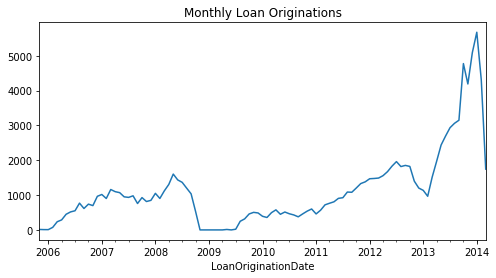

In [24]:
# Plot number of loan originations per month over the timespan of the dataset
monthly_loans['LoanStatus'].count().plot(kind='line', figsize=(8, 4))
plt.title('Monthly Loan Originations')

> This line plot of the number of loan originations per month provides a big hint as to why loan default rates were so high for completed loans. Note that the monthly loan origination counts actually drops to near zero at the end of 2008 and stays near zero until the middle of 2009. This, of course, corresponds to the financial crisis of 2008.
>
> To verify the suspicion let's plot the number of loan failures (chargedoff and defaulted) recorded per month. For this plot the CloseDate is a better x-axis than LoanOriginationDate.

In [25]:
# Create a timeseries dataframe indexed by ClosedDate and containing the LoanStatus column
ts_loans_closed = loans_closed[['ClosedDate', 'LoanStatus']].copy()
ts_loans_closed.set_index('ClosedDate', inplace=True)
ts_loans_closed.head()

,LoanStatus
ClosedDate,
2009-08-14,Completed
2009-12-17,Completed
2008-01-07,Completed
2012-12-19,Defaulted
2008-05-22,Chargedoff


In [26]:
# Groupby year
yearly_closed = ts_loans_closed.groupby(pd.Grouper(freq="Y"))
yvc = yearly_closed['LoanStatus'].value_counts(normalize=True)
df_yvc = yvc.to_frame()
df_yvc.columns = ['Value']
df_yvc.unstack(level=1, fill_value=0)

Value                               
LoanStatus Cancelled Chargedoff Completed Defaulted
ClosedDate                                         
2005-12-31  0.000000   0.000000  1.000000  0.000000
2006-12-31  0.010230   0.007673  0.734015  0.248082
2007-12-31  0.000000   0.066766  0.498659  0.434575
2008-12-31  0.000175   0.371633  0.484260  0.143931
2009-12-31  0.000000   0.336953  0.534708  0.128340
2010-12-31  0.000000   0.179858  0.757428  0.062714
2011-12-31  0.000000   0.107215  0.856913  0.035872
2012-12-31  0.000000   0.197176  0.749838  0.052986
2013-12-31  0.000000   0.218787  0.749284  0.031929
2014-12-31  0.000000   0.215250  0.764684  0.020066

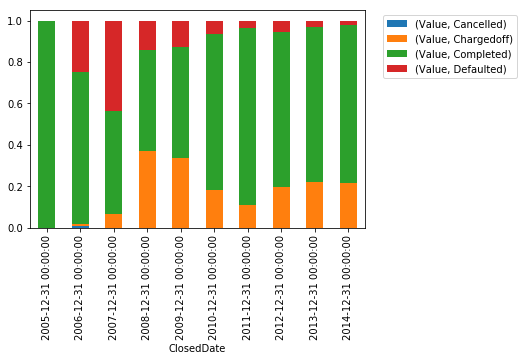

In [27]:
# Now that we have the yearly counts of LoanStatus values in separate columns of a dataframe let's plot
df_yvc.unstack(level=1, fill_value=0).plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1.04,1))

> From the above stacked bar chart we see that the suspicion about the connection between loan failure rate and the financial crisis _is somewhat_ born out. The number of chargedoff and defaulted loans in 2008 and 2009 are indeed noticible elevated. However, it also reveals that default rates were also very high in 2006 and 2007. In fact, the highest proportion of loans that closed with a LoanStatus of "Defaulted" occurred in 2007 (43.5% of the 3355 loans that closed that year).  Let's calculate this loan failure rate directly on, say, a quarterly basis to see this in more detail.

In [28]:
# Calculate loan failure rate as (defaulted + chargedoff) / (completed + defaulted + chargedoff)
quarterly_closed = ts_loans_closed.groupby(pd.Grouper(freq="Q"))
qvc = quarterly_closed['LoanStatus'].value_counts()
df_qvc = qvc.to_frame()
df_fail_rates = df_qvc.unstack(level=1, fill_value=0)
df_fail_rates['fail_rates'] = df_fail_rates.apply(lambda row: (row.LoanStatus.Chargedoff+row.LoanStatus.Defaulted)/(row.LoanStatus.Chargedoff+row.LoanStatus.Defaulted+row.LoanStatus.Completed+row.LoanStatus.Cancelled), axis = 1)
df_fail_rates

LoanStatus                                fail_rates
LoanStatus  Cancelled Chargedoff Completed Defaulted           
ClosedDate                                                     
2005-12-31          0          0         8         0   0.000000
2006-03-31          1          0        14         0   0.000000
2006-06-30          3          0        36         0   0.000000
2006-09-30          0          0        86         7   0.075269
2006-12-31          0          3       151        90   0.381148
2007-03-31          0          3       339       193   0.366355
2007-06-30          0          5       385       273   0.419306
2007-09-30          0         23       466       511   0.534000
2007-12-31          0        193       483       481   0.582541
2008-03-31          0        520       655       182   0.517318
2008-06-30          0        445       663       191   0.489607
2008-09-30          0        493       797       197   0.464022
2008-12-31          1        667       654       253   0.584127
2009-03-31          0        832       949       293   0.542430
2009-06-30          0        686       996       270   0.489754
2009-09-30          0        649      1197       247   0.428094
2009-12-31          0        595      1241       242   0.402791
2010-03-31          0        436      1679       180   0.268410
2010-06-30          0        296      1258       108   0.243081
2010-09-30          0        301      1476       117   0.220697
2010-12-31          0        335      1348        72   0.231909
2011-03-31          0        201      1879        71   0.126453
2011-06-30          0        203      2012        48   0.110915
2011-09-30          0        160      1648        67   0.121067
2011-12-31          0        237       863        82   0.269882
2012-03-31          0        274      1166        89   0.237410
2012-06-30          0        299      1244        94   0.240073
2012-09-30          0        436      1628        95   0.245947
2012-12-31          0        513      1750       131   0.269006
2013-03-31          0        653      2138       125   0.266804
2013-06-30          0        619      2170        98   0.248355
2013-09-30          0        626      2224        87   0.242765
2013-12-31          0        699      2362        69   0.245367
2014-03-31          0        590      2096        55   0.235316

Text(0, 0.5, 'Defaults + Chargedoff over Total Loans Closed')

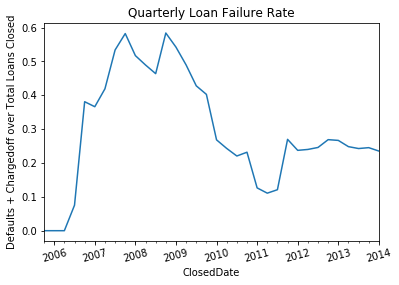

In [29]:
# plot the quarterly loan failure rates
df_fail_rates['fail_rates'].plot(kind='line', title='Quarterly Loan Failure Rate')
plt.xticks(rotation='15')
plt.ylabel('Defaults + Chargedoff over Total Loans Closed')

> This higher resolution line plot shows that the "failure rate" of loans closed during each quarter from Q4 2005 to Q1 2014 clearly shows very high default rates (>40%) during 2008 and 2009. However, default rates actually started to rise much earlier. In Q4 2006 the failure rates was 38% and it remained above 35% thru 2007. The other surprising feature evident from this plot is the high default rates on the platform in general. Aside from the first 4 quarters (likely the first year of existence) the default rate for Prosper Marketplace loans has been greater than 10%. Even the most recent 10 quarters (Q4 2011 thru Q1 2014) the default rate for closed loans is consistently north of 20%.

> Another category of interesting variables is borrower creditworthness. In particular, the following variables are needed for the planned analysis:
> * ProsperRating - The Prosper Rating assigned at the time the listing was created between AA - HR. Applicable for loans originated after July 2009.
> * ProsperScore - A custom risk score built using historical Prosper data. The score ranges from 1-10, with 10 being the best, or lowest risk score.
Applicable for loans originated after July 2009.
> * CreditScoreRangeLower - The lower value representing the range of the borrower's credit score as provided by a consumer credit rating agency.
> * CreditScoreRangeUpper - The upper value representing the range of the borrower's credit score as provided by a consumer credit rating agency.
>
> The following plots explore these data.

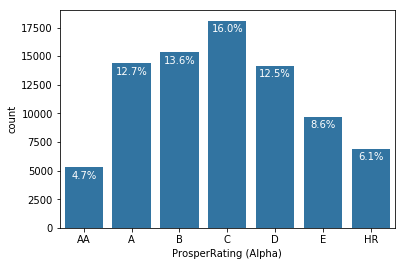

In [30]:
# Plot the distribution of ProsperRating values
base_color=sb.color_palette()[0]
#type_order=loans_clean['ProsperRating (Alpha)'].value_counts().index
type_order=['AA','A','B','C','D','E','HR']
sb.countplot(data=loans_clean, x='ProsperRating (Alpha)', color=base_color, order=type_order)
# Label bars with proportions
n_points = loans_clean.shape[0]
cat_counts = loans_clean['ProsperRating (Alpha)'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just above the top of the bar
    plt.text(loc, count-1000, pct_string, ha = 'center', color = 'w')

> This plot shows a reason looking distribution of rating values with nothing out-of-the-ordinary.
>
> The ProsperScore is another borrower creditworthness metric that might also be useful in later analysis.

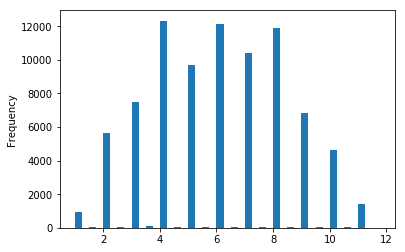

In [31]:
# Plot the distribution of ProsperScore values
bins = np.arange(1,loans_clean.ProsperScore.max()+1,0.25)
loans_clean.ProsperScore.plot(kind='hist', bins=bins)

> The variables dictionary for this dataset says that the range of values for ProsperScore should be 1-10 however there are a significant number of values of 11. These are unexpected.
>
> Since this is a quantitative variable we choose not to clean this discrepancy, but just note it. Also note that there are now fractional values that resulted from the way that we cleaned up the duplicate LoanKey values (i.e., averaged the ProsperScore values in the duplicate rows and assigned that value to one of them while deleting the rest).

> The difference between CreditScoreRangeLower & CreditScoreRangeUpper values is 19 in all cases so there is no value in analyzing both. The following plots the distribution of one of these.

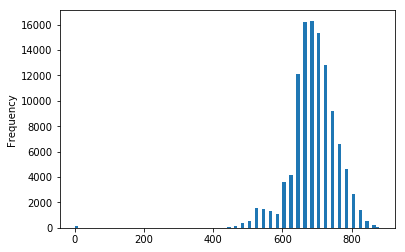

In [32]:
# Plot distribution of CreditScoreRangeLower
bins = np.arange(loans_clean.CreditScoreRangeLower.min(),loans_clean.CreditScoreRangeLower.max()+1,10)
loans_clean.CreditScoreRangeLower.plot(kind='hist', bins=bins)

> The surprise in the distribution of CreditScoreRangeLower is the outliers at 0. These must be investigated.

In [33]:
loans_clean[loans_clean.CreditScoreRangeLower == 0.0].count()

ListingKey                             133
ListingNumber                          133
ListingCreationDate                    133
CreditGrade                            133
Term                                   133
LoanStatus                             133
ClosedDate                             133
BorrowerAPR                            133
BorrowerRate                           133
LenderYield                            133
EstimatedEffectiveYield                  0
EstimatedLoss                            0
EstimatedReturn                          0
ProsperRating (numeric)                  0
ProsperRating (Alpha)                    0
ProsperScore                             0
ListingCategory (numeric)              133
BorrowerState                           89
Occupation                             101
EmploymentStatus                       101
EmploymentStatusDuration                 0
IsBorrowerHomeowner                    133
CurrentlyInGroup                       133
GroupKey   

> There are 133 rows with a zero valued CreditScoreRangeLower. In all of these cases the CreditScoreRangeUpper is exactly 19. The only other credit score/rating variables that have values for these rows is CreditGrade and it is either "NC" or "HR". "HR" means "high risk". "NC" might stand for "not calculated" but the author could not confirm this. The "ProsperRating (Alpha)", "ProsperRating (Numeric)" and "ProsperScore" variables are only populated for loans originated after 2009 and none of these CreditScoreRangeLower==0 loans have these values.
>
> One other way to gain insight into these borrowers is to see what interest rate these loans were issued at (e.g., BorrowerAPR or BorrowerRate)

In [34]:
# Extract summary statistics for BorrowerAPR for the CreditScoreRangeLower==0 rows 
loans_clean[loans_clean.CreditScoreRangeLower == 0.0].BorrowerAPR.describe()

count    133.000000
mean       0.237847
std        0.054042
min        0.066980
25%        0.202230
50%        0.245020
75%        0.287710
max        0.309620
Name: BorrowerAPR, dtype: float64

In [35]:
# Compare the above to the overall statistics for BorrowerAPR
loans_clean.BorrowerAPR.describe()

count    113041.000000
mean          0.218980
std           0.080483
min           0.006530
25%           0.156290
50%           0.209840
75%           0.283860
max           0.512290
Name: BorrowerAPR, dtype: float64

> While the above does hint at a higher interest rate for the CreditScore=0 it is not conclusive. We will explore the relationship between CreditGrade and BorrowerAPR in the bivariate exploration below, but for now let's clean these bad CreditScore values by simple dropping these values. This is justified by the fact that the range of FICO credit scores values is 300 to 850 score a value of 0 just doesn't make sense. 

In [36]:
# Set the CreditScoreRangeLower=0 and CreditScoreRangeUpper=19 to NaN
loans_clean.CreditScoreRangeUpper.replace(to_replace=19, value=np.NaN, inplace=True)
loans_clean.CreditScoreRangeLower.replace(to_replace=0, value=np.NaN, inplace=True)

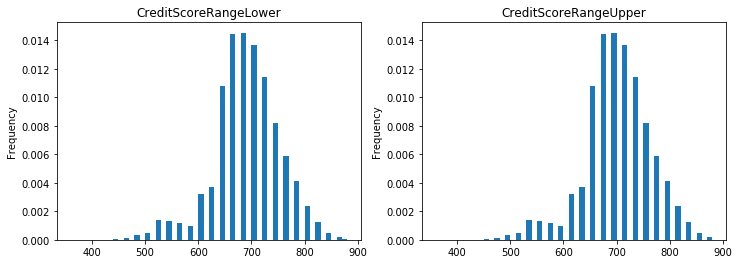

In [37]:
# As a test to the CreditScoreRangeLower/Upper cleaning let's plot these distributions 
bins = np.arange(loans_clean.CreditScoreRangeLower.min(),loans_clean.CreditScoreRangeLower.max()+1,10)
fig, ax = plt.subplots(1,2,squeeze=False,figsize = (12,4))
loans_clean.CreditScoreRangeLower.plot(kind='hist', bins=bins, ax=ax[0,0], title='CreditScoreRangeLower', density=True)
loans_clean.CreditScoreRangeUpper.plot(kind='hist', bins=bins, ax=ax[0,1], title='CreditScoreRangeUpper', density=True)

Text(0.5, 1.0, 'Distribution of Loan Terms')

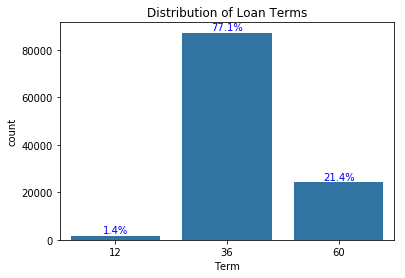

In [38]:
# Plot distribution of Term values
base_color=sb.color_palette()[0]
sb.countplot(data=loans_clean, x='Term', color=base_color)
# Label bars with proportions
n_points = loans_clean.shape[0]
cat_counts = loans_clean['Term'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):
    # get the text property for the label to get the correct count
    count = cat_counts[int(label.get_text())]
    pct_string = '{:0.1f}%'.format(100*count/n_points)
    
    # print the annotation just above the top of the bar
    plt.text(loc, count+1000, pct_string, ha = 'center', color = 'b')
    
plt.title('Distribution of Loan Terms')


> The above plot shows the distribution of loan durations (terms). 

> According to [Wikipedia](https://en.wikipedia.org/wiki/Prosper_Marketplace#Secondary_market_/_Trading_platform_-_Development_and_Termination) "On November 24, 2008, the SEC found Prosper to be in violation of the Securities Act of 1933. As a result of these findings, the SEC imposed a cease and desist order on Prosper. Due primarily to the novel nature of the peer-to-peer lending models, the SEC, after review, now treats all peer-to-peer lending transactions as sales of securities and requires that all platforms register with the SEC... In July 2009, Prosper reopened their website for lending ("investing") and borrowing after having obtained SEC registration for its loans ("notes")... A number of factors, including Prosper's decision to set the interest rates on all loans (rather than let investors choose the rates they would accept), occurred after Prosper registered with the SEC and began issuing new loan notes in July, 2009. Additionally, after Prosper began setting the rates on all loans itself, Prosper significantly tightened the minimum credit quality necessary for a borrower to receive a Prosper loan." Note that the several month period of zero loan originations seen in the time series line plot above corresponds to the time between SEC cease and desist order and subsequent relaunch.
>
> So it appears that the "relaunch" of the Prosper Marketplace that occurred in July of 2009 was a very significant event that ushered in a number of changes in business practices. Therefore, it seems appropriate that any analysis of data that spans the time of these events be cognizant of these changes. In the following a column is added to indicate which loans were originated after the relaunch (PostRelaunch).

In [39]:
# Separate the closed loans into pre-relaunch ...
pre_loans_closed = loans_clean[loans_clean.PostRelaunch == False].dropna(subset=['ClosedDate'])
pre_loans_closed.shape

(28953, 82)

In [40]:
# ... and post-relaunch
post_loans_closed = loans_clean[loans_clean.PostRelaunch == True].dropna(subset=['ClosedDate'])
post_loans_closed.shape

(26123, 82)

Text(0.5, 1.0, 'LoanStatus Distribution of Post-Relaunch Loans')

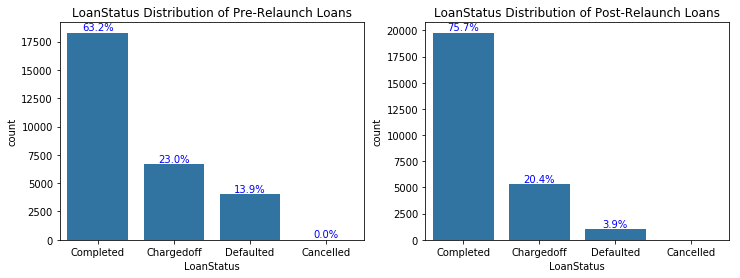

In [41]:
# Plot the distribution of the pre-relaunch and post-relaunch, closed LoanStatus categorical variable
fig, axes = plt.subplots(1,2,squeeze=False,figsize = (12,4))
base_color=sb.color_palette()[0]
type_order=['Completed','Chargedoff','Defaulted','Cancelled']
sb.countplot(data=pre_loans_closed, x='LoanStatus', color=base_color, order=type_order, ax=axes[0,0])
sb.countplot(data=post_loans_closed, x='LoanStatus', color=base_color, order=type_order, ax=axes[0,1])
locs, labels = plt.xticks() # get the current tick locations and labels

pre_points = pre_loans_closed.shape[0]
pre_counts = pre_loans_closed.LoanStatus.value_counts()
post_points = post_loans_closed.shape[0]
post_counts = post_loans_closed.LoanStatus.value_counts()

# loop through each pair of locations and labels for left subplot
plt.sca(axes[0,0])
for loc, label in zip(locs, labels):
    # get the text property for the label to get the correct count
    count = pre_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/pre_points)
    
    # print the annotation just above the top of the bar
    plt.text(loc, count+200, pct_string, ha = 'center', color = 'b')
    
plt.title('LoanStatus Distribution of Pre-Relaunch Loans')

# loop through each pair of locations and labels for left subplot
plt.sca(axes[0,1])
for loc, label in zip(locs, labels):
    # get the text property for the label to get the correct count
    try:
        count = post_counts[label.get_text()]
    except:
        break
        
    pct_string = '{:0.1f}%'.format(100*count/post_points)
    
    # print the annotation just above the top of the bar
    plt.text(loc, count+200, pct_string, ha = 'center', color = 'b')
    
plt.title('LoanStatus Distribution of Post-Relaunch Loans')


> The loan failure rate for the post-relaunch cohort of loans is clearly lower. 36.9% of pre-relaunch closed loans had a LoanStatus of either Chargedoff or Defaulted while 24.3% of the post-relaunch closed loans had a similar LoanStatus.

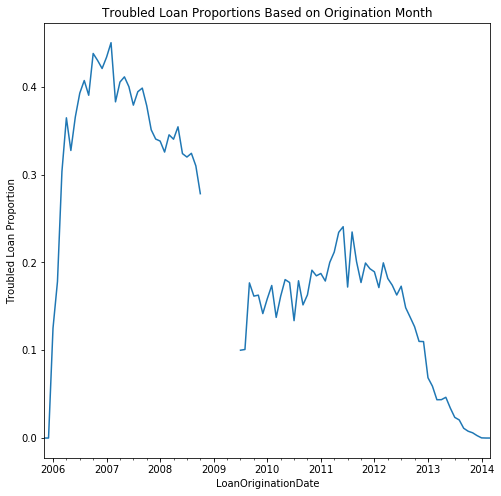

In [42]:
# Calculate and plot troubled loan rate by month of origination
monthly_loans['TroubledLoan'].agg(np.mean).plot(kind='line', figsize=(8, 8))
plt.title('Troubled Loan Proportions Based on Origination Month')
plt.ylabel('Troubled Loan Proportion');

28953 84113


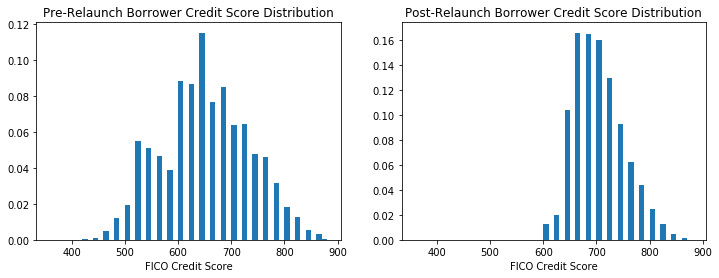

In [43]:
# Plot CreditScoreRangeLower distribution for loans originated pre- and post-relaunch
bins = np.arange(loans_clean.CreditScoreRangeLower.min(),loans_clean.CreditScoreRangeLower.max()+1,10)
fig, ax = plt.subplots(1,2,squeeze=False,figsize = (12,4))

pre = loans_clean[loans_clean.PostRelaunch == False].CreditScoreRangeLower
post = loans_clean[loans_clean.PostRelaunch == True].CreditScoreRangeLower
pre_weights=np.ones(len(pre)) / len(pre)
post_weights=np.ones(len(post)) / len(post)

print(len(pre_weights), len(post_weights))
ax[0,0].hist(x=pre, bins=bins, weights=pre_weights)
ax[0,0].set_title('Pre-Relaunch Borrower Credit Score Distribution')
ax[0,0].set_xlabel('FICO Credit Score')
ax[0,1].hist(x=post, bins=bins, weights=post_weights)
ax[0,1].set_title('Post-Relaunch Borrower Credit Score Distribution')
ax[0,1].set_xlabel('FICO Credit Score');

> The difference between the distribution of credit scores before and after relaunch is stark! The credit scores distribution of borrowers after the relaunch is significantly better.

Text(0.5, 1.0, 'Distribution of Interest Rates on Loans Before and After Relaunch')

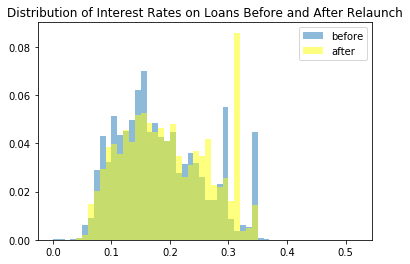

In [44]:
# Plot BorrowerAPR distribution for loans originated pre- and post-relaunch
bins = np.arange(0,loans_clean.BorrowerAPR.max()+0.01,0.01)
pre_APRs = loans_clean[loans_clean.PostRelaunch == False].BorrowerRate
post_APRs = loans_clean[loans_clean.PostRelaunch == True].BorrowerRate
pre_weights=np.ones(len(pre_APRs)) / len(pre_APRs)
post_weights=np.ones(len(post_APRs)) / len(post_APRs)
fig, ax = plt.subplots()
plt.hist(x=pre_APRs, bins=bins, weights=pre_weights, alpha=0.5, label='before')
plt.hist(x=post_APRs, bins=bins, weights=post_weights, alpha=0.5, color='yellow', label='after')
ax.legend(loc='upper right')
ax.set_title('Distribution of Interest Rates on Loans Before and After Relaunch')

> This normalized plot of histograms of BorrowerRate before and after relaunch shows that the distribution of interest rates charged on Prosper loans actually shifted upward, toward higher interest rates post-relaunch. This shift is inspite of the fact that the credit score distribution _also_ shifted significantly higher after relaunch. This is somewhat surprising because, in general, interest rates fall drastically after the financial crisis of 2008.

Text(0, 0.5, 'Proportion of Loans')

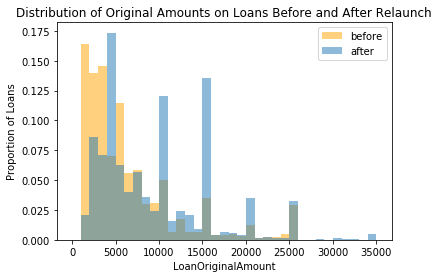

In [45]:
# Visualize loan amounts before and after relaunch
bins = np.arange(0,loans_clean.LoanOriginalAmount.max()+1000,1000)
pre_amts = loans_clean[loans_clean.PostRelaunch == False].LoanOriginalAmount
post_amts = loans_clean[loans_clean.PostRelaunch == True].LoanOriginalAmount
pre_weights=np.ones(len(pre_amts)) / len(pre_amts)
post_weights=np.ones(len(post_amts)) / len(post_amts)

fig, ax = plt.subplots()
plt.hist(x=pre_amts, bins=bins, weights=pre_weights, alpha=0.5, color='orange', label='before')
plt.hist(x=post_amts, bins=bins, weights=post_weights, alpha=0.5, label='after')
ax.legend(loc='upper right')
ax.set_title('Distribution of Original Amounts on Loans Before and After Relaunch')
ax.set_xlabel('LoanOriginalAmount')
ax.set_ylabel('Proportion of Loans')

> The loan size distribution definitely shifted toward bigger values after the Prosper relaunch. This is partly explained by the increase in the maximum loan amount from \\$25,000 to \$35,000 in 2013 as can be seen in the following timeseries plot.

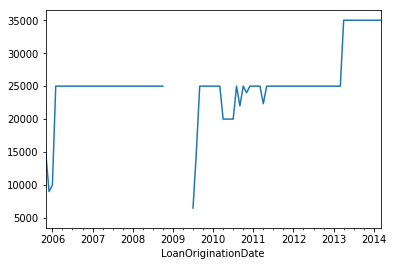

In [46]:
# Plot max loan amount timeseries
monthly_loans['LoanOriginalAmount'].max().plot(kind='line');

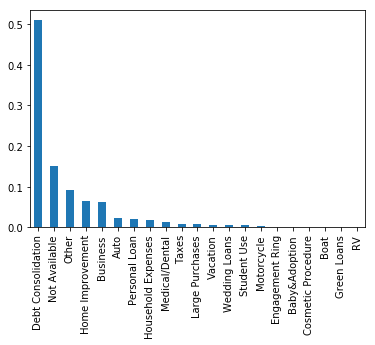

In [47]:
# Plot the distribution of ListingCategory (borrower selected purpose of the loan)
ax = loans_clean['ListingCategory (numeric)'].value_counts(normalize=True).plot(kind='bar')
cats_dict = {0:'Not Available', 1:'Debt Consolidation', 2:'Home Improvement', 3:'Business', 4:'Personal Loan', 5:'Student Use', 6:'Auto', 
              7:'Other', 8:'Baby&Adoption', 9:'Boat', 10:'Cosmetic Procedure', 11:'Engagement Ring', 12:'Green Loans', 13:'Household Expenses', 
              14:'Large Purchases', 15:'Medical/Dental', 16:'Motorcycle', 17:'RV', 18:'Taxes', 19:'Vacation', 20:'Wedding Loans'}
labels = [item.get_text() for item in ax.get_xticklabels()]
#print(labels)
# Replace numeric label with corresponding string in cats_dict
for i in range(21):
    labels[i] = cats_dict[int(labels[i])]
#print(labels)    
ax.set_xticklabels(labels)
plt.xticks(rotation='90');

> The above bar plot shows normalized ListingCategory values. These are the categories that borrowers selected when posting their listings. Debt consolidation is the clear dominant stated purpose for loans on the platform.

In [48]:
# Add a column for investor return ratio in loans_closed: 
# (LP_CustomerPayments + (LP_GrossPrincipalLoss - LP_NetPrincipalLoss) - LP_ServiceFees - LP_CollectionFees) / LoanOriginalAmount
loans_closed.loc[:,'InvestorReturnRatio'] = np.nan
loans_closed.InvestorReturnRatio = (loans_closed.LP_CustomerPayments + 
                                             (loans_closed.LP_GrossPrincipalLoss - loans_closed.LP_NetPrincipalLoss)
                                             + loans_closed.LP_ServiceFees + loans_closed.LP_CollectionFees) / loans_closed.LoanOriginalAmount
loans_closed.InvestorReturnRatio.describe()

count    55076.000000
mean         0.963456
std          0.409945
min         -0.342024
25%          0.760495
50%          1.099502
75%          1.221934
max          2.262280
Name: InvestorReturnRatio, dtype: float64

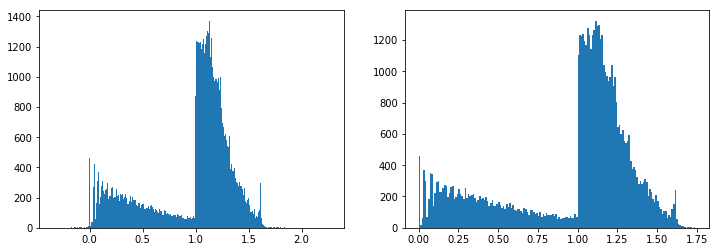

In [49]:
# Plot distribution of InvestorReturnRatios
fig, ax = plt.subplots(1,2,squeeze=False,figsize = (12,4))
bins1 = np.arange(loans_closed.InvestorReturnRatio.min(), loans_closed.InvestorReturnRatio.max()+0.01, 0.01)
ax[0,0].hist(x=loans_closed.InvestorReturnRatio, bins=bins1)
bins2 = np.arange(0, 1.75, 0.01)
ax[0,1].hist(x=loans_closed.InvestorReturnRatio, bins=bins2);

> This is a very strange looking distribution but the variable is a non-standard way of looking at investor return. A value of 1.0 says that the investor got the loan principal back but zero interest (net of fees) and a value of 0.0 says that the investor lost all of the loan principal (net of fees). The strange downward slope from a ratio of 0.0 and 1.0 may be an indication that when the borrower is close to repaying the loan principal then they are more motivated to "find a way" to do so.
>
> Another interpretation of this distribution is that it is two distinct distributions overlayed - one for "successful" loans where the borrower repays and the other for unsuccessful loans. This idea will be investigated in the bivariate exploration section below.

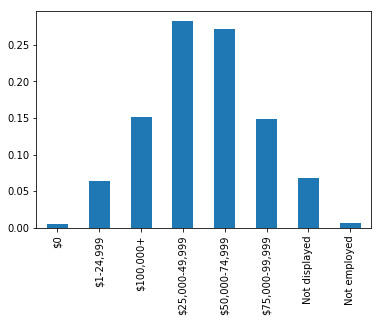

In [50]:
# Plot borrower income distribution
loans_clean.IncomeRange.value_counts(normalize=True).sort_index().plot(kind='bar')

<a id='bivar'></a>
## Bivariate Exploration

> In this section explicit relationships between variables are explored. In particular, the following interactions are analyzed.
> * Relationships between credit rating metrics
> * Credit score vs number of investors per loan
> * Credit score vs BorrowerAPR
> * Credit score vs income
> * Credit score vs loan performance
> 
> Since all of these relationships involve a metric of creditworthiness, let's start by analyzing the relationships _between_ variables that intend to measure creditworthiness.

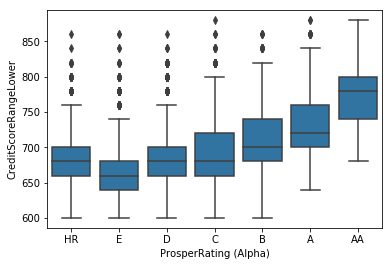

In [51]:
# Boxplot CreditScoreRangeLower vs ProsperRating (Alpha)
base_color=sb.color_palette()[0]
cat_order=['HR','E','D','C','B','A','AA']
sb.boxplot(data=loans_clean, x='ProsperRating (Alpha)', y='CreditScoreRangeLower', color=base_color, order=cat_order)

> In general this plots looks like what this author would expect - better ProsperRating values correspond to higher CreditScore values. However, the outliers are hard to interpret in this format. Let's try violin and grid plots and evaluate the results.

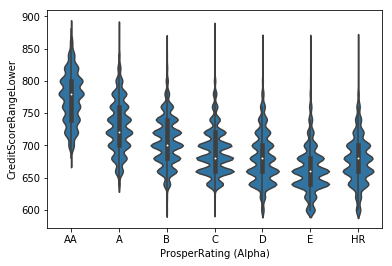

In [52]:
# Violinplot CreditScoreRangeLower vs ProsperRating (Alpha)
base_color=sb.color_palette()[0]
cat_order=['AA','A','B','C','D','E','HR']
sb.violinplot(data=loans_clean, x='ProsperRating (Alpha)', y='CreditScoreRangeLower', color=base_color, order=cat_order)

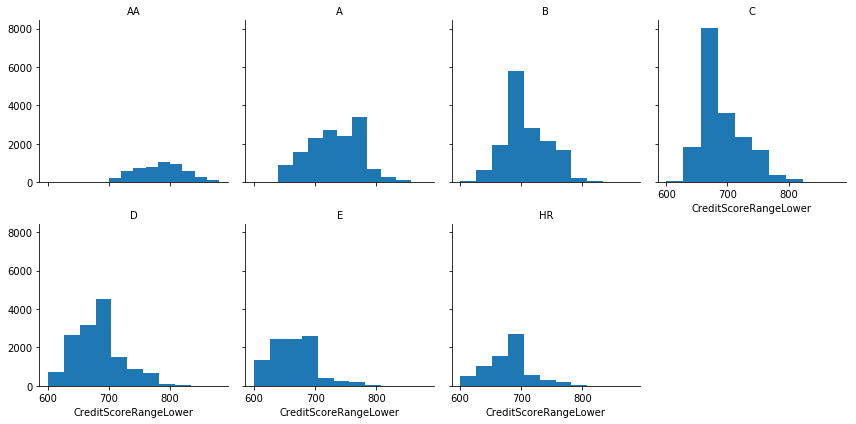

In [53]:
# Gridplot CreditScoreRangeLower vs ProsperRating (Alpha)
base_color=sb.color_palette()[0]
cat_order=['AA','A','B','C','D','E','HR']
g = sb.FacetGrid(data=loans_clean, col='ProsperRating (Alpha)', col_wrap=4, height=3, col_order=cat_order)
g.map(plt.hist, 'CreditScoreRangeLower')
g.set_titles('{col_name}')

> All three of the above plots of ProsperRating (Alpha) and CreditScoreRangeLower show that the correlation between these two metrics of creditworthness are surprisingly weak. There are definitely cases where the ProsperRating is very poor (HR or E) and the credit score is above 800! Which is ultimately better at predicting loan outcomes (e.g., failure rates) will need to be analyzed.
>
> The third direct metric of creditworthiness in this dataset is ProsperScore. Let's see how the two Prosper proprietary metrics correlate.

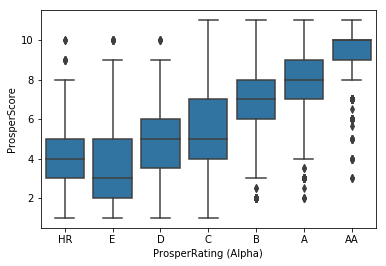

In [54]:
# Plot ProsperRating (Alpha) against ProsperScore
base_color=sb.color_palette()[0]
cat_order=['HR','E','D','C','B','A','AA']
sb.boxplot(data=loans_clean, x='ProsperRating (Alpha)', y='ProsperScore', color=base_color, order=cat_order)

> The boxplot format seems to be good for showing the correlation between ProsperRating and ProsperScore. The results look as expected except for the HR ProsperRating where the ProsperScore improves over that for the E rating. This might be due to the higher interest rates that are charged for these lowest tier borrowers more than making up for the added risk.

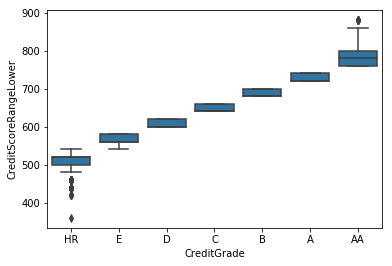

In [55]:
# Plot CreditScoreRangeLower vs CreditGrade
base_color=sb.color_palette()[0]
cat_order=['HR','E','D','C','B','A','AA']
sb.boxplot(data=loans_clean, x='CreditGrade', y='CreditScoreRangeLower', color=base_color, order=cat_order)

> There is a fourth primary creditworthiness metric in the dataset - CreditGrade. This variable is only populated for pre-relaunch loans and, based on the above boxplot, is computed directly from FICO credit score. While the values for the CreditGrade categorical variable are nearly identical to that for ProsperRating (alpha), the fact that the correlations with FICO credit score are so different indicates that the method for calualating these variables are quite different. 

[659.30207197 679.81351161 683.42387704 683.70931357 692.2624157
 693.75010255 697.79790276 712.6548007  726.49818446 749.38250429
 732.04718945] [47.98509282 37.48799402 38.39809714 36.59993841 41.87397463 42.03734529
 43.22398253 48.33199454 49.67189153 53.08865045 44.61922847]


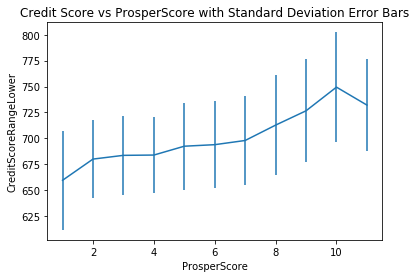

In [56]:
# Plot CreditScoreRangeLower vs ProsperScore
loans_post = loans_clean[loans_clean.PostRelaunch==True]

# set bin edges, compute centers
xbin_size = 1
xbin_edges = np.arange(0.5, loans_post.ProsperScore.max()+xbin_size, xbin_size)
xbin_centers = (xbin_edges + xbin_size/2)[:-1]

# compute statistics in each bin
data_xbins = pd.cut(loans_post['ProsperScore'], xbin_edges, right = False, include_lowest = True)
y_means = loans_post['CreditScoreRangeLower'].groupby(data_xbins).mean()
y_stds = loans_post['CreditScoreRangeLower'].groupby(data_xbins).std()
print(y_means.values, y_stds.values)
# plot the summarized data
plt.errorbar(x = xbin_centers, y = y_means.values, yerr = y_stds.values)
plt.xlabel('ProsperScore')
plt.ylabel('CreditScoreRangeLower')
plt.title('Credit Score vs ProsperScore with Standard Deviation Error Bars');

> This line plot shows the FICO credit score means vs. ProsperScore with standard deviation error bars. As with the previous comparisons of CreditScore vs ProsperRating and ProsperScore vs ProsperRaing the general correlation is as expected there is considerable variation. For example, the lowest (highest risk) ProsperScore bin encompasses borrowers with FICO credit scores from 611 to 707 within +/- one standard deviation.

Text(0.5, 1.0, 'Average Number of Investors per Loan vs Credit Score')

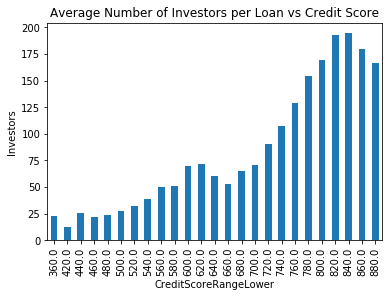

In [57]:
# Compute average number of investors per loan for each credit score bin 
loans_cs = loans_clean[['CreditScoreRangeLower','LoanOriginalAmount','Investors']].copy()
loans_cs=loans_cs[np.isfinite(loans_cs['CreditScoreRangeLower'])]

gb_cs_investors = loans_cs.groupby(by='CreditScoreRangeLower')['Investors'].sum()
gb_cs_counts = loans_cs.groupby(by='CreditScoreRangeLower')['Investors'].count()

avg_investors_per_loan = gb_cs_investors/gb_cs_counts
pd.Series(data=avg_investors_per_loan).plot(kind='bar')
plt.ylabel('Investors')
plt.title('Average Number of Investors per Loan vs Credit Score')

> The bar plot above shows the relationship between mean number of investors per loan and the credit score of the borrower.  Based this plot it appears that lenders on the Prosper Marketplace platform are attracted to borrowers with high credit scores. 

Text(0.5, 1.0, 'Investors per Loan Mean vs. ProsperRating')

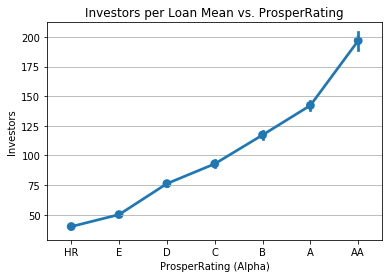

In [58]:
# Pointplot InvestorReturnRatio against ProsperRating showing means
cat_order=['HR','E','D','C','B','A','AA']
sb.pointplot(data=loans_closed, x='ProsperRating (Alpha)', y='Investors', showmeans=True, order=cat_order)
plt.grid(b=True, which='major', axis='y')
plt.title('Investors per Loan Mean vs. ProsperRating')

In [59]:
# Compute TroubledLoan proportion for each ProsperRating 
gb_prosper_rating = loans_clean.groupby(by='ProsperRating (Alpha)')['TroubledLoan'].value_counts()
df_gb = gb_prosper_rating.to_frame()
df_troubled_props = df_gb.unstack(level=1, fill_value=0)
df_troubled_props.columns = ['v_false', 'v_true']
df_troubled_props['trouble_rates'] = df_troubled_props.apply(lambda row: row.v_true/(row.v_true+row.v_false), axis = 1)
df_troubled_props

,v_false,v_true,trouble_rates
ProsperRating (Alpha),,,
A,13907,483,0.033565
AA,5227,98,0.018404
B,14656,712,0.046330
C,17033,1063,0.058742
D,12279,1891,0.133451
E,8204,1512,0.155620
HR,5343,1574,0.227555


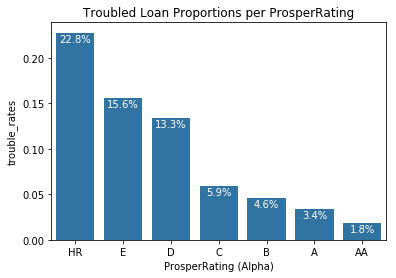

In [60]:
# Plot TroubledLoan proportions as barchart
base_color=sb.color_palette()[0]
cat_order=['HR','E','D','C','B','A','AA']
sb.barplot(data=df_troubled_props, x=df_troubled_props.index, y='trouble_rates', color=base_color, order=cat_order)
plt.title('Troubled Loan Proportions per ProsperRating')

# Annotate bars with proportions
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
i = 0
for loc, label in zip(locs, labels):
    tr = float(df_troubled_props.loc[cat_order[i], 'trouble_rates'])
    i += 1
    pct_string = '{:0.1f}%'.format(100*tr)
    
    # print the annotation just above the top of the bar
    plt.text(loc, tr-0.01, pct_string, ha = 'center', color = 'w')
    #print(pct_string)

> This bar chart clearly illustrates the association between ProsperRating and troubled loan outcomes. Let's see if the other creditworthiness metrics show such a strong correlation.

In [61]:
# Compute TroubledLoan proportion for each CreditScoreRangeLower 
trouble_credit_score = loans_clean[loans_clean.PostRelaunch==True].groupby(by='CreditScoreRangeLower')['TroubledLoan'].value_counts().to_frame().unstack(level=1, fill_value=0)
trouble_credit_score.columns = ['v_false', 'v_true']
trouble_credit_score['trouble_rates'] = trouble_credit_score.apply(lambda row: row.v_true/(row.v_true+row.v_false), axis = 1)
trouble_credit_score

,v_false,v_true,trouble_rates
CreditScoreRangeLower,,,
600.0,795,246,0.236311
620.0,1296,361,0.217864
640.0,7771,992,0.113203
660.0,12674,1288,0.092250
680.0,12682,1168,0.084332
700.0,12369,1099,0.081601
720.0,10119,814,0.074453
740.0,7232,601,0.076727
760.0,4841,385,0.073670


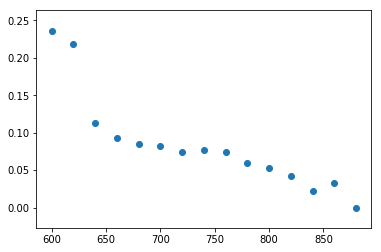

In [62]:
# Scatter plot credit score against troubled loan proportions
plt.scatter(data=trouble_credit_score, x=trouble_credit_score.index, y='trouble_rates')

> This plot also shows a strong correlation (negative in this case) between credit score range and troubled loan proportion. Probably should encode the number of loans made in each credit score range as some are quite sparse.

In [63]:
# Compute TroubledLoan proportion for each ProsperScore bin 

# set bin edges, compute centers
xbin_size = 1
xbin_edges = np.arange(0.5, loans_post.ProsperScore.max()+xbin_size, xbin_size)
xbin_centers = (xbin_edges + xbin_size/2)[:-1]

# compute statistics in each bin
data_xbins = pd.cut(loans_post['ProsperScore'], xbin_edges, right = False, include_lowest = True)

trouble_prosper_score = loans_post.groupby(data_xbins)['TroubledLoan'].value_counts().to_frame().unstack(level=1, fill_value=0)
trouble_prosper_score.columns = ['v_false', 'v_true']
trouble_prosper_score['trouble_rates'] = trouble_prosper_score.apply(lambda row: row.v_true/(row.v_true+row.v_false), axis = 1)
trouble_prosper_score

,v_false,v_true,trouble_rates
ProsperScore,,,
"[0.5, 1.5)",626,291,0.317339
"[1.5, 2.5)",5111,573,0.100809
"[2.5, 3.5)",6938,609,0.080694
"[3.5, 4.5)",11356,1056,0.085079
"[4.5, 5.5)",8578,1208,0.123442
"[5.5, 6.5)",10927,1262,0.103536
"[6.5, 7.5)",9588,902,0.085987
"[7.5, 8.5)",11046,921,0.076962
"[8.5, 9.5)",6470,415,0.060276


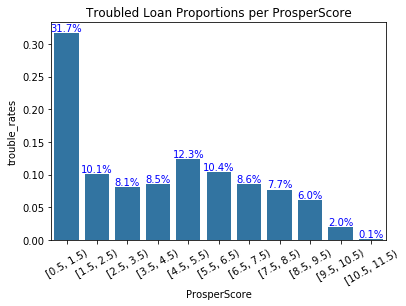

In [64]:
# bar plot ProsperScore against troubled loan proportions
base_color=sb.color_palette()[0]

sb.barplot(data=trouble_prosper_score, x=trouble_prosper_score.index, y='trouble_rates', color=base_color)
plt.title('Troubled Loan Proportions per ProsperScore')
plt.xticks(rotation='30')

# Annotate bars with proportions
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
i = 0
for loc, label in zip(locs, labels):
    tr = float(trouble_prosper_score.iloc[i, 2])
    i += 1
    pct_string = '{:0.1f}%'.format(100*tr)
    
    # print the annotation just above the top of the bar
    plt.text(loc, tr+0.003, pct_string, ha = 'center', color = 'b')
    #print(pct_string)

> The proportion of troubled loans in each ProsperScore bin is not as monotonic has that with either CreditScore or ProsperRating. 

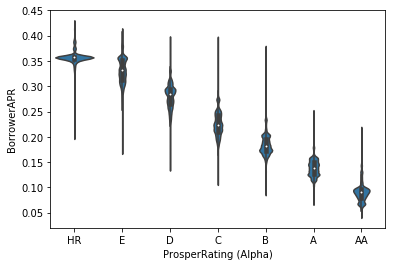

In [65]:
# Plot ProsperRating vs BorrowerAPR
base_color=sb.color_palette()[0]
cat_order=['HR','E','D','C','B','A','AA']
sb.violinplot(data=loans_clean, x='ProsperRating (Alpha)', y='BorrowerAPR', color=base_color, order=cat_order)

> This plot clearly shows the relationship between borrowers' credit ratings (ProsperRating) and borrowers' interest rate. While the range of interest rates in each credit rating category is large, the plot clearly shows where the statistical center is and that this center increases with decreasing creditworthiness as we would expect.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

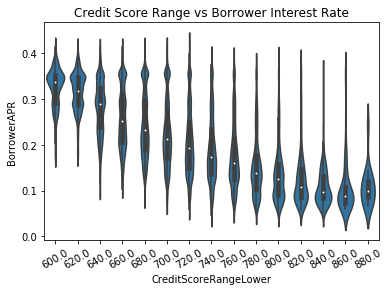

In [66]:
# plot CreditScoreRangeLower against BorrowerAPR
sb.violinplot(data=loans_clean[loans_clean.PostRelaunch==True], x='CreditScoreRangeLower', y='BorrowerAPR', color=base_color)
plt.title('Credit Score Range vs Borrower Interest Rate')
plt.ylabel('BorrowerAPR')
plt.xlabel('CreditScoreRangeLower')
plt.xticks(rotation='30')

> The violin plot of post-relaunch loans on the Prosper platform does convey where the center of the distribution of interest rates was; however, the distribution is quite broad. In fact, the distribution of interest rates within each credit score range appears broader than that per ProsperRating.

Text(0.5, 1.0, 'Mean PercentFunded per Loan vs. ProsperRating')

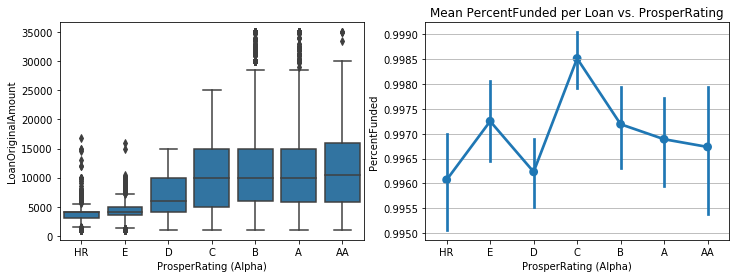

In [67]:
fig, ax = plt.subplots(1,2,squeeze=False,figsize = (12,4))
plt.sca(ax[0,0])
# Plot LoanOriginalAmount against ProsperRating
base_color=sb.color_palette()[0]
cat_order=['HR','E','D','C','B','A','AA']
sb.boxplot(data=loans_clean, x='ProsperRating (Alpha)', y='LoanOriginalAmount', color=base_color, order=cat_order)

plt.sca(ax[0,1])
# Pointplot InvestorReturnRatio against ProsperRating showing means
sb.pointplot(data=loans_closed, x='ProsperRating (Alpha)', y='PercentFunded', showmeans=True, order=cat_order)
plt.grid(b=True, which='major', axis='y')
plt.title('Mean PercentFunded per Loan vs. ProsperRating')

> The distribution of LoanOriginalAmounts per ProsperRating reveals that lower tier borrowers are getting smaller loan amounts than higher tier borrowers. Either these borrowers are only requesting smaller loans or requests for higher amounts are being denied. The plot of average PercentFunded per loan does not indicate that this difference was due to inability to get funding; however, larger loans from this lower credit quality borrowers might just be getting denied which would not show up in this dataset.

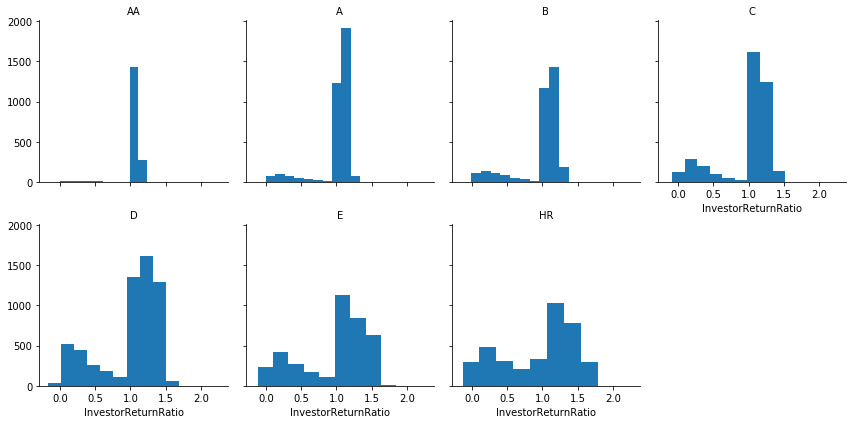

In [68]:
# Gridplot InvestorReturnRatio vs ProsperRating (Alpha)
base_color=sb.color_palette()[0]
cat_order=['AA','A','B','C','D','E','HR']
g = sb.FacetGrid(data=loans_closed, col='ProsperRating (Alpha)', col_wrap=4, height=3, col_order=cat_order)
g.map(plt.hist, 'InvestorReturnRatio')
g.set_titles('{col_name}')

> The above facet grid shows the distribution of IinvestorReturnRatio values for loans made to borrowers of different ProsperRatings. It clearly shows that the investor returns on loans to riskier borrowers have a wider spread in return ratios - both to lower values (because of higher frequency of defaults) and to _higher_ values (because of the higher interest rates charged). 

Text(0.5, 1.0, 'InvestorReturnRatio Statistics vs. ProserRating')

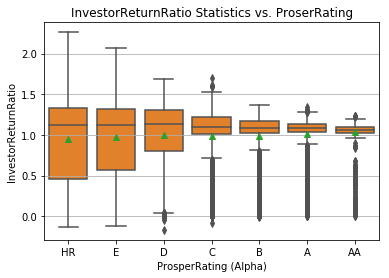

In [69]:
# box plot InvestorReturnRatio against ProsperRating
base_color=sb.color_palette()[1]
cat_order=['HR','E','D','C','B','A','AA']
sb.boxplot(data=loans_closed, x='ProsperRating (Alpha)', y='InvestorReturnRatio', color=base_color, order=cat_order, showmeans=True)
plt.grid(b=True, which='major', axis='y')
plt.title('InvestorReturnRatio Statistics vs. ProserRating')

> The boxplot of InvestorReturnRatio vs ProsperRating provides an even better look at the median return ratio in each ProsperRating category. Note that the median value for the lower three creditwortiness grades (i.e., D, E and HR) are actually _better_ than this statistic for the higher creditwortiness grades; however, the risk of loan default is also significantly higher.

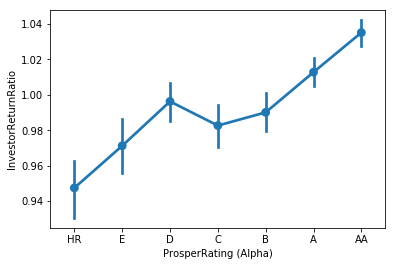

In [70]:
# Pointplot InvestorReturnRatio against ProsperRating showing means
cat_order=['HR','E','D','C','B','A','AA']
sb.pointplot(data=loans_closed, y='InvestorReturnRatio', x='ProsperRating (Alpha)', showmeans=True, order=cat_order)

> This pointplot of InvestorReturnRatio means vs ProsperRating shows that the mean return is worse for lower quality borrowers. This justifies the bias that investors on the Prosper platform have for higher creditworthiness borrowers that we saw in the number of investors per loan vs credit score plot.

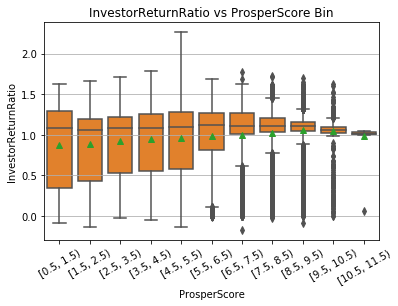

In [71]:
# box plot InvestorReturnRatio against ProsperScore bins
# set bin edges, compute centers
xbin_size = 1
xbin_edges = np.arange(0.5, loans_closed.ProsperScore.max()+xbin_size, xbin_size)

# compute statistics in each bin
prosper_score_bins = pd.cut(loans_closed['ProsperScore'], xbin_edges, right = False, include_lowest = True).to_frame()
prosper_score_bins['InvestorReturnRatio']=loans_closed['InvestorReturnRatio']
sb.boxplot(data=prosper_score_bins, x='ProsperScore', y='InvestorReturnRatio', color=base_color, showmeans=True)
plt.grid(b=True, which='major', axis='y')
plt.title('InvestorReturnRatio vs ProsperScore Bin')
plt.xticks(rotation='30');

> The above boxplot shows InvestorReturnRatio statistics per bin of the ProsperScore. According to the Prosper [webpage](https://www.prosper.com/plp/general-prosper_score/) "the Prosper score estimates the probability of a loan going “bad,” where “bad” is the probability of going 60+ days past due within the first twelve months from the date of loan origination". So it appears this variable was designed for a very specific purpose. However comparing this plot to the previous one showing InvestorReturnRatio vs ProsperRating, it is hard to argue that the two differ significantly beyond the additional levels offered by ProsperScore.

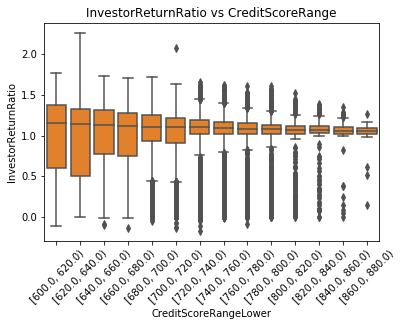

In [72]:
# box plot InvestorReturnRatio against CreditScoreRanges
post_loans_closed = loans_closed[loans_clean.PostRelaunch == True].dropna(subset=['ClosedDate'])

# set bin edges, compute centers
xbin_size = 20
xbin_edges = np.arange(600, post_loans_closed.CreditScoreRangeLower.max()+xbin_size, xbin_size)

# compute statistics in each bin
credit_score_bins = pd.cut(loans_closed['CreditScoreRangeLower'], xbin_edges, right = False, include_lowest = True).to_frame()
credit_score_bins['InvestorReturnRatio']=post_loans_closed['InvestorReturnRatio']
sb.boxplot(data=credit_score_bins, x='CreditScoreRangeLower', y='InvestorReturnRatio', color=base_color)
plt.title('InvestorReturnRatio vs CreditScoreRange')
plt.xticks(rotation='45');

1.192251403684052
0.45166011436605924


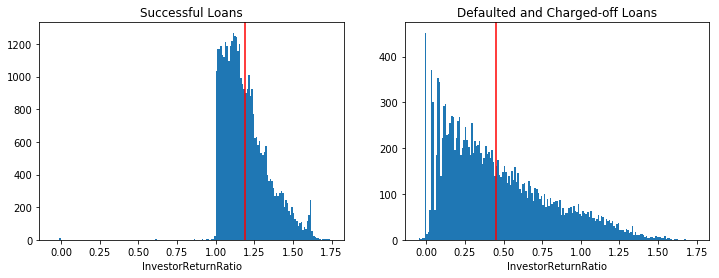

In [73]:
# plot distribution of InvestorReturnRatio values for the different LoanStatus
fig, ax = plt.subplots(1,2,squeeze=False,figsize = (12,4))
bins = np.arange(-0.05, 1.75, 0.01)
ax[0,0].hist(x=loans_closed[loans_closed.LoanStatus == 'Completed'].InvestorReturnRatio, bins=bins)
ax[0,0].set_title('Successful Loans')
ax[0,0].set_xlabel('InvestorReturnRatio')
ax[0,0].axvline(loans_closed[loans_closed.LoanStatus == 'Completed'].InvestorReturnRatio.mean(), color='r')

ax[0,1].hist(x=loans_closed[loans_closed.LoanStatus != 'Completed'].InvestorReturnRatio, bins=bins);
ax[0,1].set_title('Defaulted and Charged-off Loans')
ax[0,1].set_xlabel('InvestorReturnRatio')
ax[0,1].axvline(loans_closed[loans_closed.LoanStatus != 'Completed'].InvestorReturnRatio.mean(), color='r')
print(loans_closed[loans_closed.LoanStatus == 'Completed'].InvestorReturnRatio.mean())
print(loans_closed[loans_closed.LoanStatus != 'Completed'].InvestorReturnRatio.mean())

> The above two histograms confirms the speculation made during univariate exploration of the InvestorReturnRatio variable regarding the "strange" distribution. In the above it is clear that successful loans (LoanStatus of Completed) have an InvestorReturnRatio of 1.0 or greater meaning that the investor got the loan principal back and some interest although fees appear to have dragged a few of these loans below 1.0. On the other hand unsuccessful loans had an InvestorReturnRatio mean of less than 50%.

17


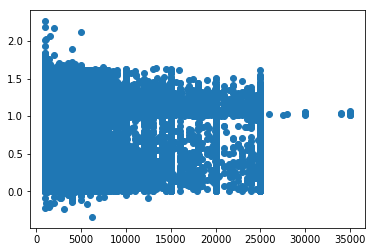

In [74]:
# Scatter plot LoanOriginalAmount vs InvestorReturnRatio
plt.scatter(data=loans_closed, x='LoanOriginalAmount', y='InvestorReturnRatio')
print(loans_closed[loans_closed.LoanOriginalAmount > 25000].shape[0])

> The striking thing about the above scatter plot of loan amounts vs investor return ratios is that there are no defaulted loans of original amount of more than \\$25,000. This is likely due to the relative sparcity of loans in this size range that closed before the end of the dataset. Prosper only increased the maximum loan amount to \\$35,000 in 2013 and the latest date in the dataset is Q1 2014.

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

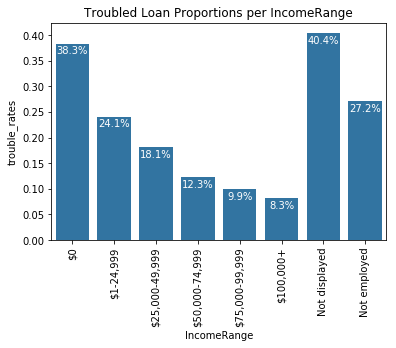

In [75]:
# Compute TroubledLoan proportion for each IncomeRange 
gb_income_range = loans_clean.groupby(by='IncomeRange')['TroubledLoan'].value_counts()
df_gb = gb_income_range.to_frame()
df_troubled_props = df_gb.unstack(level=1, fill_value=0)
df_troubled_props.columns = ['v_false', 'v_true']
df_troubled_props['trouble_rates'] = df_troubled_props.apply(lambda row: row.v_true/(row.v_true+row.v_false), axis = 1)
df_troubled_props

# Plot TroubledLoan proportions vs IncomeRange as barchart
base_color=sb.color_palette()[0]
cat_order=['$0','$1-24,999','$25,000-49,999','$50,000-74,999','$75,000-99,999','$100,000+','Not displayed','Not employed']
sb.barplot(data=df_troubled_props, x=df_troubled_props.index, y='trouble_rates', color=base_color, order=cat_order)
plt.title('Troubled Loan Proportions per IncomeRange')

# Annotate bars with proportions
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
i = 0
for loc, label in zip(locs, labels):
    tr = float(df_troubled_props.loc[cat_order[i], 'trouble_rates'])
    i += 1
    pct_string = '{:0.1f}%'.format(100*tr)
    
    # print the annotation just above the top of the bar
    plt.text(loc, tr-0.02, pct_string, ha = 'center', color = 'w')
    
plt.xticks(rotation='90')

> Troubled loan rates plotted by IncomeRange category looked surprising similar to troubled loan rates vs ProsperRating.

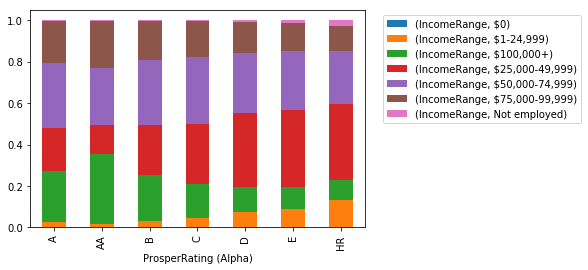

In [76]:
gb_prosper_rating_income = loans_clean.groupby('ProsperRating (Alpha)')['IncomeRange']
df_rating_income = gb_prosper_rating_income.value_counts(normalize=True).to_frame()
df_rating_income.unstack(level=1, fill_value=0).plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1.04,1))

> This stacked bar chart clearly shows the relationship between IncomeRange and ProsperRating. Not surprisingly, higher income borrowers have higher credit rating by proportion of borrowers.

<a id='multivar'></a>
## Multivariate Exploration


Text(0.5, 1.0, 'Fraudulent(?) Loan Count vs ProsperRating & ProsperScore')

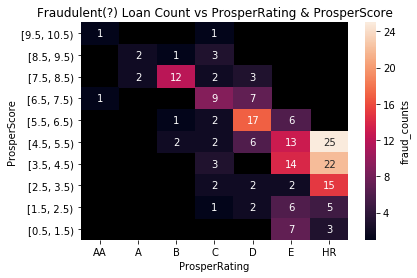

In [77]:
# Plot count of defaulted laans that had an InvesterReturnRatio of close to zero against ProsperScore and ProsperRating.
# These loans could represent fraud.
prosper_score_bins['ProsperRating']=loans_closed['ProsperRating (Alpha)']
fraud = prosper_score_bins[prosper_score_bins.InvestorReturnRatio.between(-0.01,0.01)]
fraud_counts = fraud.groupby(['ProsperRating', 'ProsperScore']).size()
fraud_counts = fraud_counts.reset_index(name="fraud_counts")
fraud_counts = fraud_counts.pivot(index='ProsperScore', columns='ProsperRating', values='fraud_counts')

# rearrange order of columns
cat_order=['AA','A','B','C','D','E','HR']
fraud_counts = fraud_counts[cat_order]

# rearrange order of rows
fraud_counts.sort_index(ascending=False, inplace=True)

g = sb.heatmap(fraud_counts, annot=True, fmt='.0f', cbar_kws={'label':'fraud_counts'})
g.set_facecolor('black')
plt.title('Fraudulent(?) Loan Count vs ProsperRating & ProsperScore')

> The phenominon of a loan with near zero or negative investor return ratio (i.e., zero customer payments) is considered here to be potentially fraudulent. These loans are counted and plotted in the above heatmap against ProsperRating and ProsperScore. Based on the Prosper [webpage](https://www.prosper.com/plp/general-prosper_score/) ProsperScore was designed to predict probability of a loan "going bad" within the first year and these zero-payment loans certainly fix that criteria. This plot doesn't provide overwhelming evidence of success. This plot says that the ProperRating is more strongly correlated to these potentially fraudulent occurences. The ProsperScore values that correspond to the peak of the fraud counts are in the middle of the 1-11 range instead of the lower end values which should indicate higher risk.